# $\beta$-VAE trained on the Fashion-MNIST dataset

In this project I have trained a basic VAE built on a CNN-architecture to learn the distribution of the Fashion-MNIST dataset and then be able to generate samples from it.

The frist step is to load in the data, and then visulize a few datapoints as an exmple of how the dataset is distributed.
To run file it is needed to download the Fashion-MNIST dataset which is easily done with torchvision.

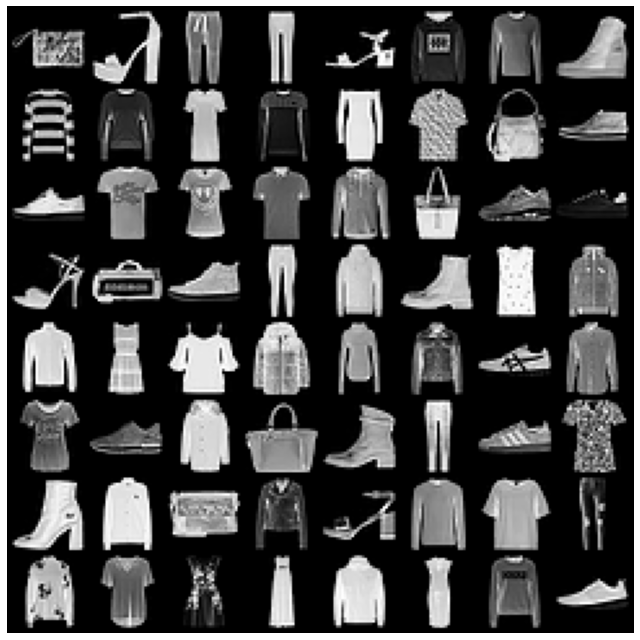

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy

plt.style.use('ggplot')

# Pytorch
import torch
import torchvision
from torchvision import datasets, transforms

# Project specifik modules
from utils import load_dataset, load_small_dataset
from models import BetaVAE_fc
from solver import Solver


#We define the label names for alter if we want to know what kind of cloethes we are actually generating.
label_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


train_set, val_set, test_set = load_dataset()
small_train = load_small_dataset(num_samples=10000)

# Loads one batch to plot it
batch_size = 128
_, (X_train, _) = next(enumerate(torch.utils.data.DataLoader(train_set, batch_size=batch_size)))

image_grid = torchvision.utils.make_grid(X_train[0:64], nrow=8)

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(image_grid.permute(1, 2, 0), aspect = 'auto', cmap = 'viridis')
plt.axis('off')
plt.tight_layout()

In [10]:
kwargs = {'learning_rate':1e-5,
          'batch_size' :   256,
          'lr_rate_decay': .9,
          'decay_every_': 2}


kl_weight = kwargs['batch_size']/len(train_set)

model = BetaVAE_fc(in_channels=1, latent_dim=3, beta=3, kl_weight= kl_weight)

solver = Solver(model, train_set, val_set, test_set, **kwargs)
#small_solver = Solver(model, small_train, val_set, test_set, **kwargs)

In [11]:
#small_solver.overtrain_sample()
solver.train(15)

Validation: 100%|██████████| 47/47 [00:02<00:00, 20.30it/s, Epoch=15/15, KL_loss=2.27, Loss=0.452, MSE_loss=0.415]


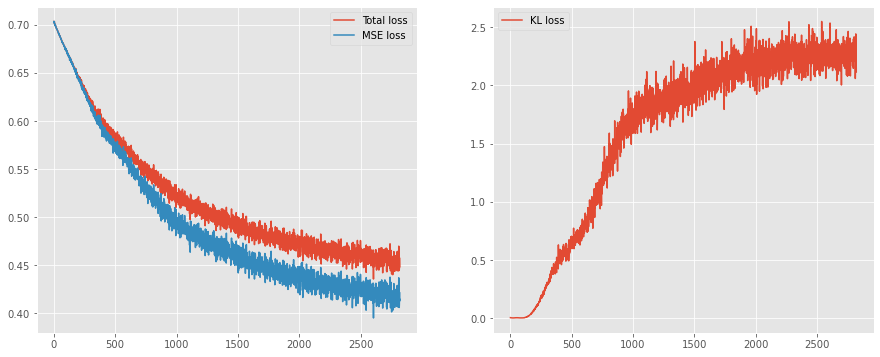

In [12]:
solver.plot_training_loss()

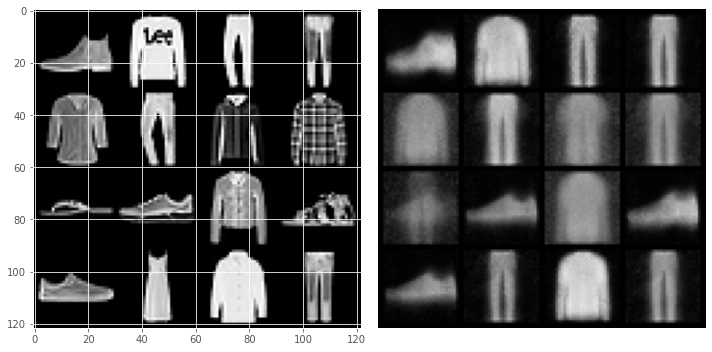

In [5]:
_, (X_train, _) = next(enumerate(torch.utils.data.DataLoader(test_set, batch_size=batch_size)))
output, (_, _) = model.forward(X_train)

fig, axis = plt.subplots(1, 2, figsize = (10, 5))
grid_1 = torchvision.utils.make_grid(X_train[0:16], nrow=4)
grid_2 = torchvision.utils.make_grid(output.detach()[0:16], nrow=4)

axis[0].imshow(grid_1.permute(1, 2, 0), aspect = 'auto', cmap = 'viridis')
axis[1].imshow(grid_2.permute(1, 2, 0), aspect = 'auto', cmap = 'viridis')

plt.axis('off')
plt.tight_layout()

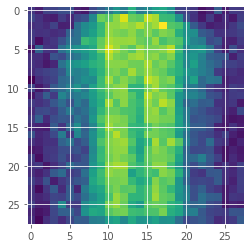

In [6]:
x = model.sample(1)
plt.imshow(x.view(28, 28).detach().numpy())

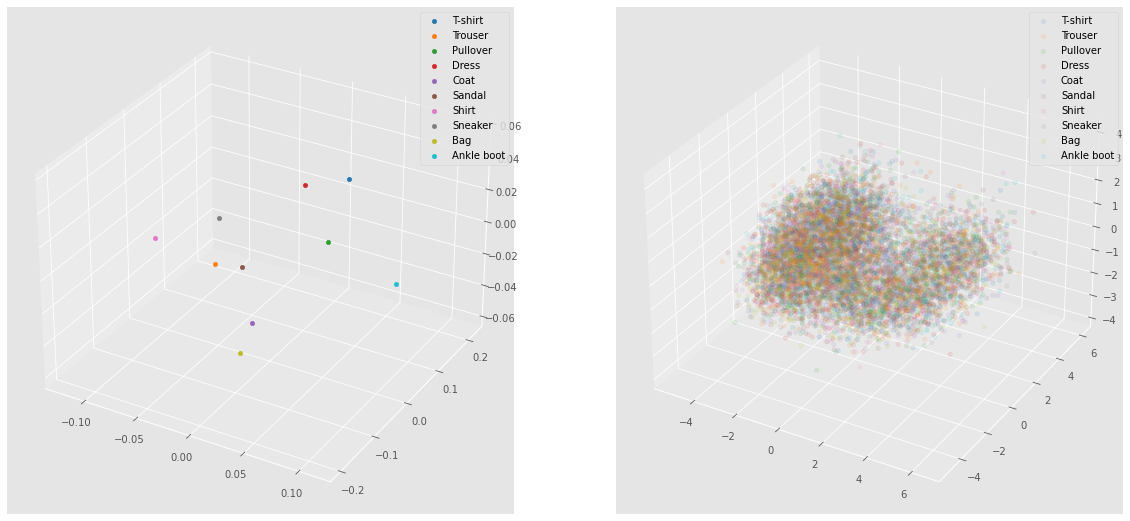

In [9]:
from sklearn.decomposition import PCA
# Projected down to a lower dim with PCA
predictions = PCA(3).fit_transform(solver.predict().detach().numpy())


label = test_set.targets

fig = plt.figure(figsize=(20, 10))
ax_1 = fig.add_subplot(121, projection='3d')
ax_2 = fig.add_subplot(122, projection='3d')


for i in torch.unique(label):
    mask = label == i
    tmp_data = predictions[mask]
    ax_1.scatter(tmp_data.mean(0)[0], tmp_data.mean(0)[1], tmp_data.mean(0)[2], label=label_names[i], c = list(mcolors.TABLEAU_COLORS)[i])
    ax_2.scatter(tmp_data[:, 0], tmp_data[:, 1], tmp_data[:, 2], label=label_names[i], c = list(mcolors.TABLEAU_COLORS)[i], alpha=0.1)

ax_1.legend()
ax_2.legend()


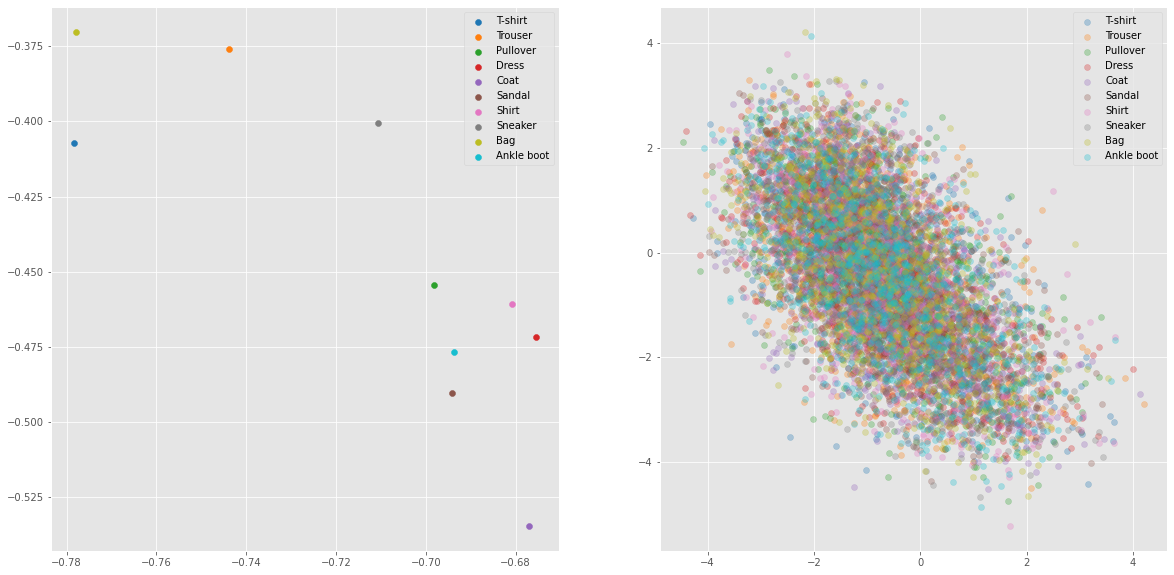

In [8]:
from sklearn.decomposition import PCA
# Projected down to a lower dim with PCA
predictions = solver.predict().detach().numpy()

label = test_set.targets

fig = plt.figure(figsize=(20, 10))
ax_1 = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)


for i in torch.unique(label):
    mask = label == i
    tmp_data = predictions[mask]
    ax_1.scatter(tmp_data.mean(0)[0], tmp_data.mean(0)[1], label=label_names[i], c = list(mcolors.TABLEAU_COLORS)[i])
    ax_2.scatter(tmp_data[:, 0], tmp_data[:, 1], label=label_names[i], c = list(mcolors.TABLEAU_COLORS)[i], alpha=0.3)

ax_1.legend()
ax_2.legend()
